# Building a Meta-Learner for Algorithm Preselection

This notebook summarizes the intent to extract characteristics from time-series, which could indicate best algorithm performance. 

Purpose:
- Compute a broad set of features from the GutenTAG dataset with unique anomalies
- Analyze potential correlations of features and algorithm family performance

Author: Dennis Huber

Date: 26.08.2024

Usage:
- Run `feature_extraction.py` with your desired specs on high performance hardware to yield the features 
- Source your extracted features for analysis or use the features extracted in this work 
    - `features/features_20_samples_20_njobs.csv`
    - `features/features_50_samples_20_njobs.csv`


In [2]:
import pandas as pd

FEATURE_SET_1 = pd.read_csv('features/features_20_samples_20_njobs.csv', index_col=0)
FEATURE_SET_2 = pd.read_csv('features/features_50_samples_20_njobs.csv', index_col=0)

## Statistical Analysis
We perform a paired t-test on each feature to assess if the differences between the 20-sample and 50-sample datasets are statistically significant. The test compares the means of the same feature across the two datasets. A low p-value indicates that the feature has changed significantly due to the increase in sample size. This analysis helps identify which features are most affected by the change in the number of samples and if we need to further increase the samples used in feature extraction.

In [3]:
from scipy.stats import ttest_rel
import pandas as pd
import matplotlib.pyplot as plt

def compare_features(feature_set_1: pd.DataFrame, feature_set_2: pd.DataFrame, p_value_threshold: float = 0.05, return_significant_only: bool = False) -> pd.DataFrame:
    """Compare features between two feature sets using paired t-tests and identify those with significant differences.

    This function performs paired t-tests on corresponding features from two input DataFrames to determine if there are 
    statistically significant differences between them. The results can either include all features with their p-values 
    or only those that are statistically significant based on the specified p-value threshold.

    :param feature_set_1: A DataFrame representing the first set of features.
    :param feature_set_2: A DataFrame representing the second set of features.
    :param p_value_threshold: The threshold for determining statistical significance (default is 0.05).
    :param return_significant_only: A boolean flag indicating whether to return only the features with p-values below 
                                    the threshold (default is False, returning all features).

    :returns: A DataFrame containing features and their corresponding p-values. If 'return_significant_only' is True, 
              only features with p-values below the threshold are returned.
    """
    # Check if both feature sets contain the same features
    if (feature_set_1.index == feature_set_2.index).all():
        print('Same features were extracted in both cases. Can continue with analysis.')
    else:
        raise ValueError('Different features contained in both files. Has to be the same.')
    
    p_values = []
    for feature in feature_set_1:
        stat, p_value = ttest_rel(feature_set_2[feature], feature_set_1[feature])
        p_values.append((feature, p_value))
    
    # Convert p_values to a DataFrame for easier interpretation
    p_values_df = pd.DataFrame(p_values, columns=['Feature', 'P-Value'])
    
    # Identify features with significant changes (e.g., p-value < 0.05)
    significant_features = p_values_df[p_values_df['P-Value'] < p_value_threshold]
    
    print(f"Number of features with significant differences (p-value < {p_value_threshold}): {len(significant_features)}/{len(p_values_df)}")

    return significant_features if return_significant_only else p_values_df


### Compare: Feature Set 20 Samples vs. 50 Samples

In [4]:
significant_features_2050 = compare_features(FEATURE_SET_1, FEATURE_SET_2, return_significant_only=True)

Same features were extracted in both cases. Can continue with analysis.


C:\Users\user\anaconda3\envs\robAD\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Number of features with significant differences (p-value < 0.05): 625/773


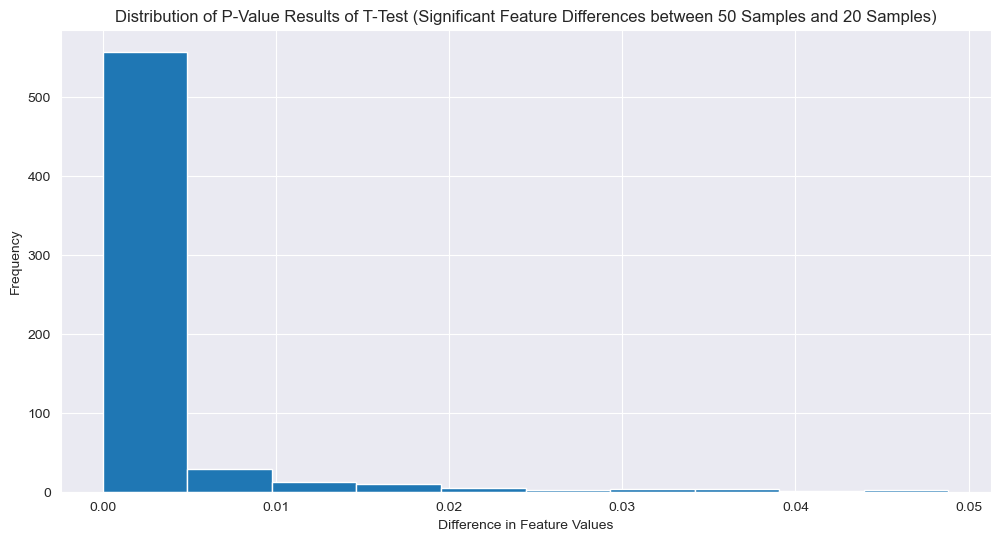

In [5]:
import matplotlib.pyplot as plt

# Visualize the distribution of differences
plt.figure(figsize=(12, 6))
plt.hist(significant_features_2050['P-Value'].values.flatten())
plt.title('Distribution of P-Value Results of T-Test (Significant Feature Differences between 50 Samples and 20 Samples)')
plt.xlabel('Difference in Feature Values')
plt.ylabel('Frequency')
plt.show()

More than 80% of the features change significantly with an increase of samples used in the feature extraction process. This means that more samples are needed for feature extraction to reach higher consistency. We take the extra step and perform feature extraction with 100 samples.

In [6]:
FEATURE_SET_3 = pd.read_csv('features/features_100_samples_30_njobs.csv', index_col=0)
significant_features_50100 = compare_features(FEATURE_SET_2, FEATURE_SET_3, return_significant_only=True)

Same features were extracted in both cases. Can continue with analysis.


C:\Users\user\anaconda3\envs\robAD\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Number of features with significant differences (p-value < 0.05): 420/773


With an increase from 50 to 100 samples the change in features reduces. Less than 46% show a significant difference, meaning the feature calculation got more consistent. We attempt to calculate the features based on all available samples. However, it is important to note that in the cases above, the dataset was at an equilibrium. The sample reduction process makes sure that all algorithm families are equally represented (e.g. 100 samples per algorithm family). Since now we are using the whole dataset (after preprocessing ref. `preprocessing_and_analysis_tsad_evaluation_results.ipynb`) we no longer have an equilibrium. Let's analyze the distribution.

In [7]:
def load_and_preprocess_eval_results():
    # Load
    eval_results = pd.read_csv('datasets/tsad_evaluation_results_preprocessed.csv') # ROC_AUC values
    
    # Filter to data used for feature extraction (match conditions)
    is_correct_collection = eval_results.collection == 'GutenTAG'
    is_unique_anomaly = eval_results['unique_anomaly_type']
    is_unsupervised = eval_results.dataset_training_type == 'UNSUPERVISED'
    
    eval_results_filtered = eval_results.loc[is_correct_collection & is_unique_anomaly & is_unsupervised]

    # Preprocessing
    eval_results_filtered = eval_results_filtered.copy() # avoid df error
    eval_results_filtered['anomaly_kind'] = eval_results_filtered['anomaly_kind'].apply(lambda x: eval(x)[0]) # List to string for anomaly kind
    return eval_results_filtered

eval_results = load_and_preprocess_eval_results()

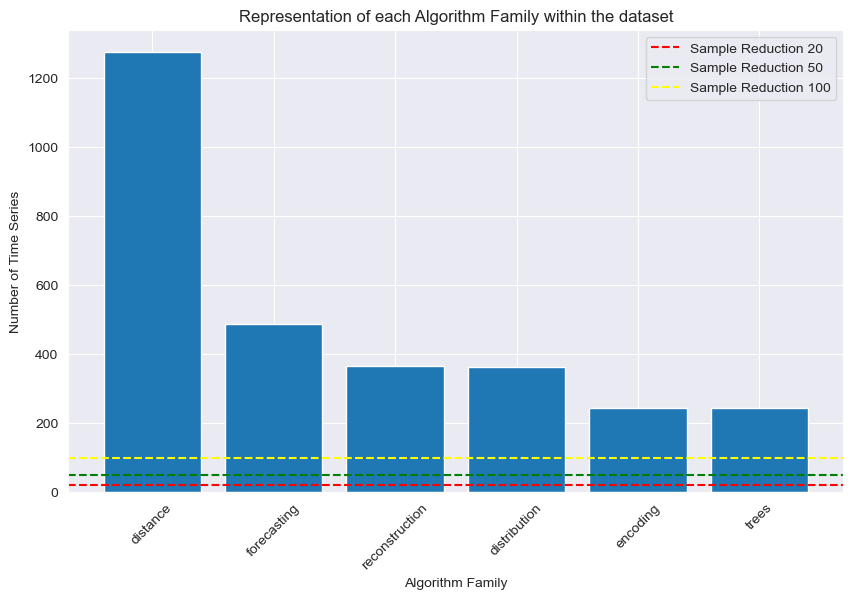

In [8]:
plt.figure(figsize=(10, 6))
algo_counts = eval_results['algo_family'].value_counts()
plt.bar(algo_counts.index, algo_counts.values)

# Labels
plt.title('Representation of each Algorithm Family within the dataset')
plt.xlabel('Algorithm Family')
plt.ylabel('Number of Time Series')
plt.xticks(rotation=45)

# Add horizontal lines with legend
plt.axhline(20, color='red', linestyle='--', label='Sample Reduction 20')
plt.axhline(50, color='green', linestyle='--', label='Sample Reduction 50')
plt.axhline(100, color='yellow', linestyle='--', label='Sample Reduction 100')
plt.legend()

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


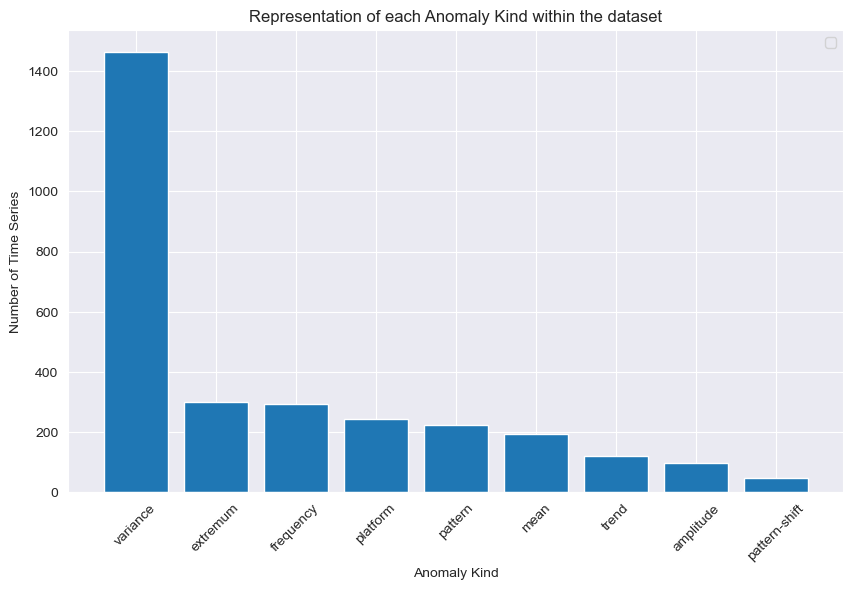

In [9]:
plt.figure(figsize=(10, 6))
anomaly_counts = eval_results['anomaly_kind'].value_counts()
plt.bar(anomaly_counts.index, anomaly_counts.values)

# Labels
plt.title('Representation of each Anomaly Kind within the dataset')
plt.xlabel('Anomaly Kind')
plt.ylabel('Number of Time Series')
plt.xticks(rotation=45)

plt.show()

In [10]:
anomaly_counts

anomaly_kind
variance         1464
extremum          300
frequency         293
platform          242
pattern           222
mean              194
trend             121
amplitude          98
pattern-shift      48
Name: count, dtype: int64

The plot reveals a significant variation in their representation within the dataset. 
- **distance** algorithms have the highest representation, with 1276 samples, possibly due to their broad applicability in various time series analysis tasks.
- **forecasting**, with 488 samples, also has a substantial presence, reflecting the importance of predictive modeling and time series forecasting techniques.
- **reconstruction** (366 samples) and **distribution** (364 samples) have a moderate representation.
- **encoding** and **trees**, each with 244 samples, are the least represented.

Overall, the distribution shows a clear preference towards distance-based features, followed by forecasting, with other families playing more niche roles in feature extraction. This suggests that the features extracted for the **distance** family might be more consistent than for **trees**, as the previous analysis has shown that consistency increases with the number of samples used in automated feature extraction.

## Correlation Analysis

In [11]:
FEATURES = FEATURE_SET_3 # Features to use for analysis

In [12]:
df = eval_results.groupby(['anomaly_kind', 'algo_family'])['ROC_AUC'].mean()

index_mapper = {
    0: 'forecasting', 
    1: 'distribution', 
    2: 'reconstruction', 
    3: 'encoding', 
    4: 'distance',
    5: 'trees'
} # from `feature_extraction.py`

features = FEATURES.rename(index=index_mapper)
features.index.name = 'algo_family'

We use Spearman's coefficient in this case because it measures the strength of monotonic relationships without assuming linearity or normal distribution, making it ideal for assessing correlations between time series features and ROC AUC values in anomaly detection algorithms.

In [33]:
# Compute correlations
merged_df = df.reset_index().merge(features, left_on='algo_family', right_index=True).set_index(['anomaly_kind', 'algo_family'])
correlations = merged_df.corr(method='spearman')['ROC_AUC'].dropna().drop('ROC_AUC')
sorted_features = correlations.abs().sort_values(ascending=False).index
correlations[sorted_features]

test_data__value_count__value_-1                      -0.428811
test_data__value_count__value_0                       -0.428811
test_data__sum_of_reoccurring_values                   0.428811
test_data__sum_of_reoccurring_data_points              0.428811
test_data__ratio_value_number_to_time_series_length   -0.428811
                                                         ...   
test_data__fft_coefficient__attr_"angle"__coeff_90     0.148585
test_data__fft_coefficient__attr_"angle"__coeff_88    -0.148585
test_data__fft_coefficient__attr_"angle"__coeff_86    -0.148585
test_data__fft_coefficient__attr_"angle"__coeff_85    -0.148585
test_data__fft_coefficient__attr_"angle"__coeff_21    -0.148585
Name: ROC_AUC, Length: 712, dtype: float64

In [52]:
correlation_threshold = 0.4
relevant_features = correlations.loc[correlations.abs() >= correlation_threshold]
print(f"{len(relevant_features)} relevant correlations. {len(correlations) - len(relevant_features)} are considered irrelevant because they are |p| < 0.4.")

11 relevant correlations. 701 are considered irrelevant because they are |p| < 0.4.


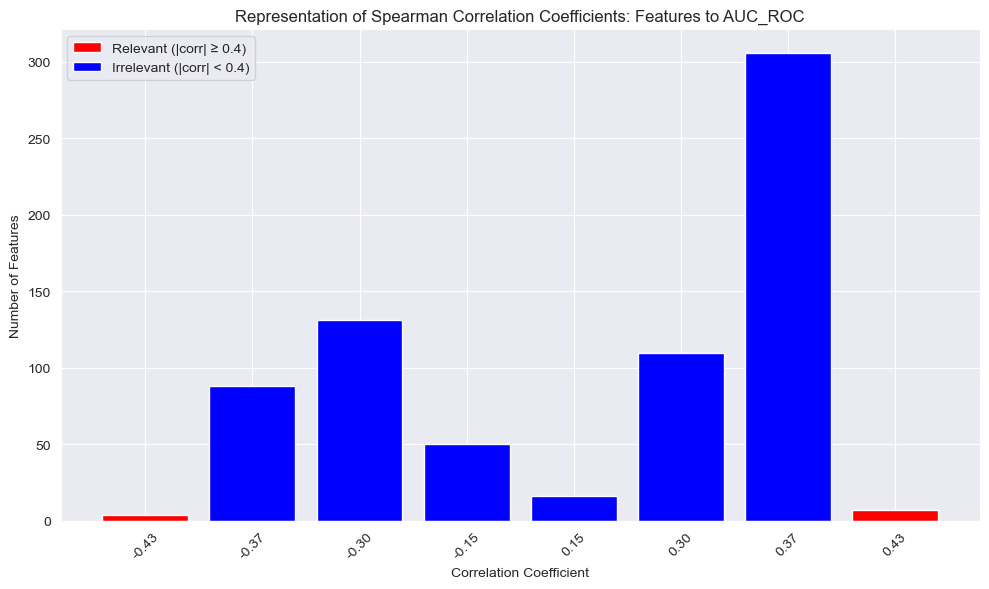

In [53]:
from matplotlib.patches import Patch

plt.figure(figsize=(10, 6))
coeff_counts = correlations.value_counts()
sorted_coeffs = coeff_counts.index.sort_values()
coeff_labels = ["{:.2f}".format(x) for x in sorted_coeffs]
counts = coeff_counts[sorted_coeffs].values
colors = ['red' if abs(x) >= correlation_threshold else 'blue' for x in sorted_coeffs] # Red for |corr| >= 0.4 (Relevant), Blue otherwise (Irrelevant)

plt.bar(coeff_labels, counts, color=colors)
plt.title('Representation of Spearman Correlation Coefficients: Features to AUC_ROC')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Number of Features')
plt.xticks(rotation=45)
legend_elements = [
    Patch(facecolor='red', label='Relevant (|corr| ≥ 0.4)'),
    Patch(facecolor='blue', label='Irrelevant (|corr| < 0.4)')
]
plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

In [54]:
print(list(relevant_features.index))

['test_data__longest_strike_below_mean', 'test_data__percentage_of_reoccurring_values_to_all_values', 'test_data__percentage_of_reoccurring_datapoints_to_all_datapoints', 'test_data__sum_of_reoccurring_values', 'test_data__sum_of_reoccurring_data_points', 'test_data__ratio_value_number_to_time_series_length', 'test_data__large_standard_deviation__r_0.15000000000000002', 'test_data__quantile__q_0.1', 'test_data__fft_coefficient__attr_"angle"__coeff_0', 'test_data__value_count__value_0', 'test_data__value_count__value_-1']


Conclusion:

The correlation matrix displays both positive and negative correlations between `ROC_AUC` values and various features extracted from the GutenTAG dataset:

1. **Moderate Negative Correlation**: Several features show a moderate negative correlation with `ROC_AUC`, with values around -0.41. This suggests an inverse relationship. 

2. **Moderate Positive Correlation**: A few features display moderate positive correlations around 0.41 with `ROC_AUC`. This implies a positive relationship.

3. **Interpretation of Feature Impact**: The presence of both positive and negative correlations indicates that different features influence the `ROC_AUC` in different ways. Some features may contribute positively to the model's discriminative ability, while others may detract from it.

The fact that the correlations are moderate, rather than strong, suggests that no single feature overwhelmingly determines the `ROC_AUC`. The results suggest further optimization and refinement of the feature set.

In a further step we try to use smaller time frames for feature extraction